# RecSys
Modelo do tipo recuperação

## Importando bibliotecas necessárias

In [101]:
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from dataset import MovieLens
from models import  MovieLensRecSys

import torch.nn as nn
import pandas as pd
import torch
import numpy as np

Carregando Tensor Board

In [60]:
writer = SummaryWriter('runs/movie-lens')
writer.flush()

Configurando dispositivo para utilizar GPU se possível; caso contrário, CPU

In [66]:
mode = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(mode)
device

device(type='cuda')

In [67]:
torch.set_default_device(device)

In [68]:
generator = torch.Generator(device)

## Carregando dados do Movie Lens

In [69]:
df_movie_lens = MovieLens('./data/movie-lens/raw/ratings.csv', device)

In [70]:
pd.Series(df_movie_lens.ratings).value_counts(normalize=True)

4.0    0.265957
3.0    0.198808
5.0    0.131015
3.5    0.130271
4.5    0.084801
2.0    0.074884
2.5    0.055040
1.0    0.027877
1.5    0.017762
0.5    0.013586
Name: proportion, dtype: float64

## Carregando dados

Dividindo dataset entre conjunto de treinamento, validação e teste

In [71]:
dataset_length = len(df_movie_lens)

train_length = int(dataset_length * 0.7)
valid_length = int(dataset_length * 0.15)
test_length  = dataset_length - train_length - valid_length

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    dataset=df_movie_lens,
    lengths=(train_length, valid_length, test_length),
    generator=generator
)

Ajustando dataset para ser utilizado pelo PyTorch como um iterável que retorna lotes de dados a cada iteração

In [72]:
BATCH_SIZE = 4

In [73]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=generator)
validation_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Após isso, toda vez que o DataLoader for requisitado, ele retornará um lote (batch) de 8 itens

In [74]:
dataiter = iter(train_loader)
batch = next(dataiter)
batch

{'users': tensor([131, 331, 599, 379], device='cuda:0'),
 'movies': tensor([ 698,  686, 1004, 2038], device='cuda:0'),
 'ratings': tensor([3, 4, 2, 3], device='cuda:0')}

## Criando modelo de RecSys

Criando modelo de RecSys no estilo de torre-dupla

Contando quantidade de clientes e produtos distintos envolvidos em compras

In [75]:
n_users = df_movie_lens.n_unique_users
n_movies = df_movie_lens.n_unique_movies
n_users, n_movies

(610, 9724)

Instanciando modelo RecSys, configurando otimizador, taxa de aprendizado e função custo

In [76]:
model = MovieLensRecSys(n_users, n_movies).to(device)
model

MovieLensRecSys(
  (users_embedding): Embedding(610, 32)
  (movies_embedding): Embedding(9724, 32)
  (fully_conn_1): Linear(in_features=64, out_features=32, bias=True)
  (relu_1): ReLU()
  (dropout_1): Dropout(p=0.2, inplace=False)
  (fully_conn_2): Linear(in_features=32, out_features=16, bias=True)
  (relu_2): ReLU()
  (dropout_2): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)

In [77]:
model.eval()
prev = model(batch)
prev

tensor([[ 0.0173],
        [ 0.0307],
        [ 0.2136],
        [-0.0349]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [78]:
writer.add_graph(model, batch)
writer.flush()

In [79]:
step_size = 3
optimizer = torch.optim.Adam(model.parameters())
scheaduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.7)
loss_function = nn.MSELoss()

Criando o ciclo de treinamento

In [80]:
EPOCHS = 2

In [81]:
model.train()
training_loss = 0.0

for epoch in range(EPOCHS):

    for i, train_batch in enumerate(train_loader):
        # predições do modelo (y-predito)
        predictions = model(train_batch)
        # calculando tamanho do lote retornado
        batch_length = len(train_batch['ratings'])
        # reformatando y-verdeiro para fical igual ao formato da saída do modelo (y-predito)
        ratings = train_batch['ratings'].view(batch_length, -1).to(torch.float32)
        # calculando o erro do modelo
        loss = loss_function(predictions, ratings)
        # somano erro durante o treinamento
        training_loss += loss.sum().item()
        # executando ajuste dos pesos no modelo via algoritmo de retropropagação
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 999: # a cada 1000 interações de mini-lotes

            validation_loss = 0.0

            model.eval()

            for j, validation_batch in enumerate(validation_loader):

                validation_predictions = model(validation_batch)
                # calculando tamanho do lote retornado
                validation_batch_length = len(validation_batch['ratings'])
                # reformatando y-verdeiro para fical igual ao formato da saída do modelo (y-predito)
                validation_ratings = validation_batch['ratings'].view(validation_batch_length, -1).to(torch.float32)
                # calculando o erro do modelo
                val_loss = loss_function(validation_predictions, validation_ratings)
                # somando erro de validaçao
                validation_loss += val_loss.sum().item()

            model.train()

            avg_training_loss = training_loss / (batch_length * 1000)
            avg_validation_loss = validation_loss / len(validation_loader)

            print('epoch: %d - batch: %5d - trainig loss: %.5f - validation loss: %.5f' % (epoch + 1, i + 1, avg_training_loss, avg_validation_loss))

            writer.add_scalars(
                main_tag='Training vs. Validation Loss',
                tag_scalar_dict={
                    'Training': avg_training_loss,
                    'Validation': avg_validation_loss
                },
                global_step=epoch * len(train_loader) + i
            )

            training_loss = 0.0

epoch: 1 - batch:  1000 - trainig loss: 0.62872 - validation loss: 1.23111
epoch: 1 - batch:  2000 - trainig loss: 0.39247 - validation loss: 1.16221
epoch: 1 - batch:  3000 - trainig loss: 0.36671 - validation loss: 1.10378
epoch: 1 - batch:  4000 - trainig loss: 0.35667 - validation loss: 1.12713
epoch: 1 - batch:  5000 - trainig loss: 0.32808 - validation loss: 1.05951
epoch: 1 - batch:  6000 - trainig loss: 0.30781 - validation loss: 1.06153
epoch: 1 - batch:  7000 - trainig loss: 0.31027 - validation loss: 1.06840
epoch: 1 - batch:  8000 - trainig loss: 0.30893 - validation loss: 1.01496
epoch: 1 - batch:  9000 - trainig loss: 0.29410 - validation loss: 1.00497
epoch: 1 - batch: 10000 - trainig loss: 0.27597 - validation loss: 1.01225
epoch: 1 - batch: 11000 - trainig loss: 0.29581 - validation loss: 1.00365
epoch: 1 - batch: 12000 - trainig loss: 0.28842 - validation loss: 0.99444
epoch: 1 - batch: 13000 - trainig loss: 0.28235 - validation loss: 0.99762
epoch: 1 - batch: 14000 -

In [82]:
torch.save(model, './model/MovieLensRecSys.pt')

## Avaliando o modelo

In [153]:
model = torch.load('./model/MovieLensRecSys.pt', weights_only=False).to(device)
model.eval()

MovieLensRecSys(
  (users_embedding): Embedding(610, 32)
  (movies_embedding): Embedding(9724, 32)
  (fully_conn_1): Linear(in_features=64, out_features=32, bias=True)
  (relu_1): ReLU()
  (dropout_1): Dropout(p=0.2, inplace=False)
  (fully_conn_2): Linear(in_features=32, out_features=16, bias=True)
  (relu_2): ReLU()
  (dropout_2): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)

Calculando o erro quadrádico médio

In [84]:
full_test_dataset = test_dataset[::]

In [85]:
test_true = full_test_dataset['ratings']

with torch.no_grad():
    test_pred = model(full_test_dataset).squeeze(1)

(test_pred - test_true).pow(2).mean()

tensor(0.9128, device='cuda:0')

precisão e recall dos K-produtos (Precision@K and Recall@K)

In [86]:
from collections import defaultdict

users_pred_true = defaultdict(list)

with torch.no_grad():

    for i, test_data in enumerate(test_loader):

        users = test_data['users']
        movies = test_data['movies']
        ratings = test_data['ratings']

        output = model(test_data)

        for j in range(len(users)):

            user_id = users[j].item()
            book_id = movies[j].item()

            pred_ratings = output[j][0].item()
            true_ratings = ratings[j].item()

            users_pred_true[user_id].append((pred_ratings, true_ratings))

            print(f'customer_id: {user_id}; product_id: {book_id}; true_ratings: {true_ratings}; pred_ratings: {pred_ratings}')

customer_id: 437; product_id: 40; true_ratings: 3; pred_ratings: 2.3452868461608887
customer_id: 379; product_id: 1446; true_ratings: 4; pred_ratings: 3.492722511291504
customer_id: 297; product_id: 2968; true_ratings: 3; pred_ratings: 2.1649229526519775
customer_id: 605; product_id: 2903; true_ratings: 3; pred_ratings: 3.5373411178588867
customer_id: 412; product_id: 907; true_ratings: 5; pred_ratings: 4.352304935455322
customer_id: 504; product_id: 4918; true_ratings: 5; pred_ratings: 4.049440860748291
customer_id: 231; product_id: 7070; true_ratings: 3; pred_ratings: 2.9479193687438965
customer_id: 368; product_id: 1251; true_ratings: 3; pred_ratings: 3.174893379211426
customer_id: 281; product_id: 2100; true_ratings: 4; pred_ratings: 3.6686086654663086
customer_id: 516; product_id: 1546; true_ratings: 2; pred_ratings: 2.1649229526519775
customer_id: 560; product_id: 4791; true_ratings: 5; pred_ratings: 3.6338307857513428
customer_id: 248; product_id: 7437; true_ratings: 4; pred_rat

In [124]:
list_thresholds = [2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
list_precisions = []
list_recalls = []
list_f1_scores = []

k=100
   
for threshold in list_thresholds:

    print(f'metrics for "{threshold}" as a threshold at {k} movies\n')
    precisions = dict()
    recalls = dict()

    for uid, user_pred_true in users_pred_true.items():

        # ordenando as predições de filmes assistdos pelo usuário
        user_pred_true.sort(key=lambda x: x[0], reverse=True)
        # registrando o número de filmes relevantes
        n_rel = sum((true_p >= threshold) for (_, true_p) in user_pred_true)
        # regitrando o número de filmes recomendados que foram preditos como relevantes para o top K filmes
        n_rec_k = sum((pred >= threshold) for (pred, _) in user_pred_true[:k])
        # registrando o número de filmes recomendados que são realmente relevantes para o top K filmes
        n_rec_and_rec_k = sum(
            ((true_p >= threshold) and (pred >= threshold))
            for (pred, true_p) in user_pred_true[:k]
        )

        # proporção de filmes recomendados que são relevantes
        precisions[uid] = n_rec_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # proporção de filmes relevantes que foram recomendados
        recalls[uid] = n_rec_and_rec_k / n_rel if n_rel != 0 else 0
        
    precision = sum(prec for prec in precisions.values()) / len(precisions) * 100
    recall = sum(rec for rec in recalls.values()) / len(recalls) * 100
    F1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f'[threshold - {threshold}] precision@{k}: {precision}')
    print(f'[threshold - {threshold}] recall@{k}: {recall}')
    print(f'[threshold - {threshold}] F1_score@{k}: {F1_score}')
    
    list_precisions.append(precision)
    list_recalls.append(recall)
    list_f1_scores.append(F1_score)
    
df_metrics = pd.DataFrame(
    data={
        'Threshold': list_thresholds,
        'Precision': list_precisions,
        'Recall': list_recalls,
        'F1': list_f1_scores,
    }
)

metrics for "2.5" as a threshold at 100 movies

[threshold - 2.5] precision@100: 85.90728712301262
[threshold - 2.5] recall@100: 95.93099745055731
[threshold - 2.5] F1_score@100: 90.6428672191716
metrics for "3.0" as a threshold at 100 movies

[threshold - 3.0] precision@100: 86.73729309972875
[threshold - 3.0] recall@100: 90.89836742212881
[threshold - 3.0] F1_score@100: 88.76909415843204
metrics for "3.5" as a threshold at 100 movies

[threshold - 3.5] precision@100: 58.373162908751134
[threshold - 3.5] recall@100: 49.37046307132811
[threshold - 3.5] F1_score@100: 53.495695128655775
metrics for "4.0" as a threshold at 100 movies

[threshold - 4.0] precision@100: 30.30268053901861
[threshold - 4.0] recall@100: 10.406483788039584
[threshold - 4.0] F1_score@100: 15.492548617798061
metrics for "4.5" as a threshold at 100 movies

[threshold - 4.5] precision@100: 3.831489234449761
[threshold - 4.5] recall@100: 1.5020862845519596
[threshold - 4.5] F1_score@100: 2.1581122862033357
metrics fo

In [125]:
df_metrics

,Threshold,Precision,Recall,F1
0,2.5,85.907287,95.930997,90.642867
1,3.0,86.737293,90.898367,88.769094
2,3.5,58.373163,49.370463,53.495695
3,4.0,30.302681,10.406484,15.492549
4,4.5,3.831489,1.502086,2.158112
5,5.0,0.000000,0.000000,0.000000


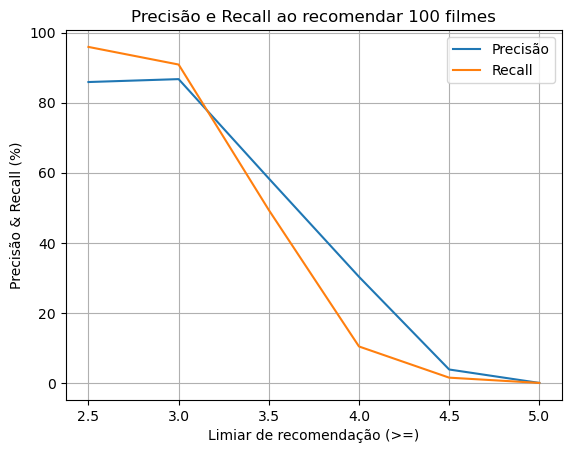

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    data=df_metrics,
    x='Threshold',
    y='Precision',
    label='Precisão'
)

sns.lineplot(
    data=df_metrics,
    x='Threshold',
    y='Recall',
    label='Recall'
)

plt.grid()
plt.legend()
plt.ylabel('Precisão & Recall (%)')
plt.xlabel('Limiar de recomendação (>=)')
plt.title('Precisão e Recall ao recomendar 100 filmes')
plt.savefig('./images/precision_recall_at_100.png')
plt.show()

Salvando modelo

# Investigando embeddings

In [151]:
unique_movies = np.unique(df_movie_lens.movies)
sample_movies = np.random.choice(unique_movies, size=1000, replace=False)

In [155]:
movies_movies_tensor = torch.from_numpy(sample_movies).to(device)

with torch.no_grad():
    movies_embeddings = model.movies_embedding(movies_movies_tensor)

In [156]:
sample_movies_ids = df_movie_lens.get_original_movie_id(sample_movies)
df_movies = pd.read_csv('./data/movie-lens/raw/movies.csv')
movies_genres = df_movies.loc[df_movies['movieId'].isin(sample_movies_ids), 'title'].values.tolist()

In [157]:
writer.add_embedding(
    mat=movies_embeddings,
    metadata=movies_genres
)
writer.flush()
writer.close()